In [11]:
import os, pathlib
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

### Analyzing target distribution

In the data preparation script, we split the data such that the label distribution is the same across the train, validation, and test sets. We performed a 70-15-15 split. Now, we'll just take a look at the target distribution. First, we'll define a function for obtaining the target distribution for any subset of the data split.

In [2]:
def get_label_distribution(root_dir, normalize=True):
    _, labels, _ = next(os.walk(train_dir))
    label_cnt = {}
    for label in labels:
        label_dir = train_dir + label
        _, _, files = next(os.walk(label_dir))
        label_cnt[label] = len(files)

    if normalize:
        total_cnt = float(sum(list(label_cnt.values())))
        label_cnt = dict(
            map(
                lambda item: (item[0], round((item[1] / total_cnt), 3)),
                label_cnt.items()
            )
        )
    return dict(sorted(label_cnt.items()))

Now, we can inspect the relative frequency of any data subset. Since they're all equal, we will just inspect the training data.

In [3]:
train_dir = '../species_data/train/'
valid_dir = '../species_data/valid/'
test_dir = '../species_data/test/'

In [4]:
# Get label distribution
train_label_dist = get_label_distribution(train_dir)
train_label_dist

{'antelope_duiker': 0.15,
 'bird': 0.1,
 'blank': 0.134,
 'civet_genet': 0.147,
 'hog': 0.059,
 'leopard': 0.137,
 'monkey_prosimian': 0.151,
 'rodent': 0.122}

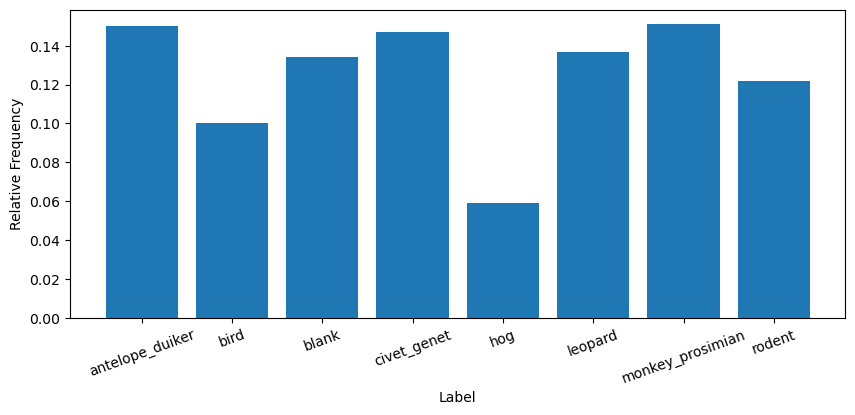

In [5]:
# Plot label distribution
plt.figure(figsize=(10, 4))
plt.bar(train_label_dist.keys(), train_label_dist.values())
plt.xlabel('Label')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=20)
plt.show()

We can see that there is a slight imbalance in the target distribution, but most of the labels have a frequency of roughly 12% plus or minus 2%.

### Choosing evaluation metrics

Since the class imbalance is not severe, accuracy may be a good metric to use. In addition, we can consider the F1 score, which in a binary classification setting, is the harmonic mean of the precision and recall metrics. Thus, the F1 score provides a balanced evaluation of the classifier's performance on individual labels. In a multi-class classification setting, we can compute the F1 score individually for each label, thus obtaining $K$ scores for each of the $K$ classes. Then, we can compute take an unweighted average (`macro` average) or a weighted average (`weighted` average) across the classes.

### Inspecting Images

Let's take a look at some of the images in our training set to get a feel for the classification task. First, we'll define a function to get one random image from the training set for each class.

In [6]:
def get_image_samples(root_dir):
    _, labels, _ = next(os.walk(root_dir))
    random_images = {}
    for label in labels:
        label_dir = root_dir / pathlib.Path(label)
        _, _, files = next(os.walk(label_dir))
        random_images[label] = label_dir / pathlib.Path(random.choice(files))
    return random_images

Now we'll define a function to plot a set of randomly selected images, and then we will go ahead and plot a couple subsets of randomly selected images to get a feel for our data.

In [7]:
def plot_image_samples(root_dir):
    image_samples = get_image_samples(root_dir)
    image_samples = sorted(image_samples.items())
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img = load_img(image_samples[i][1], target_size=(150, 150))
        ax.imshow(img)
        ax.set_title(image_samples[i][0])
        ax.axis('off')

    plt.show()

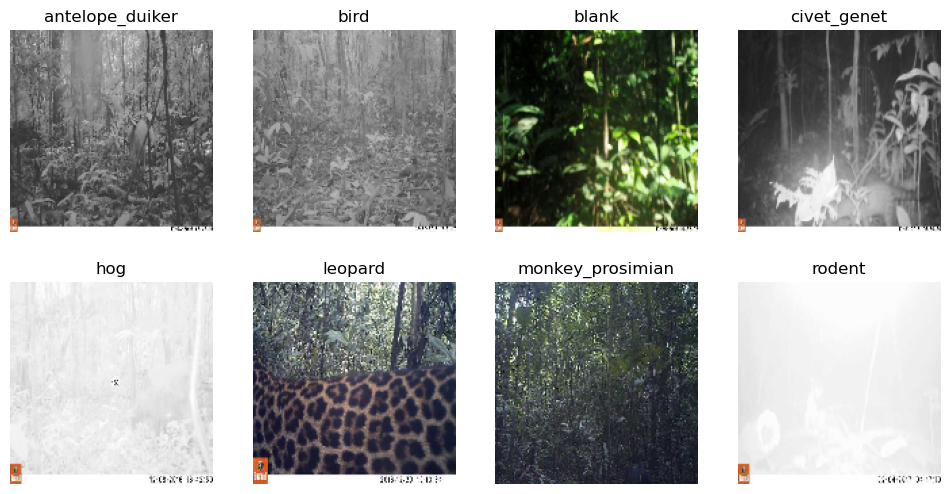

In [8]:
plot_image_samples(train_dir)

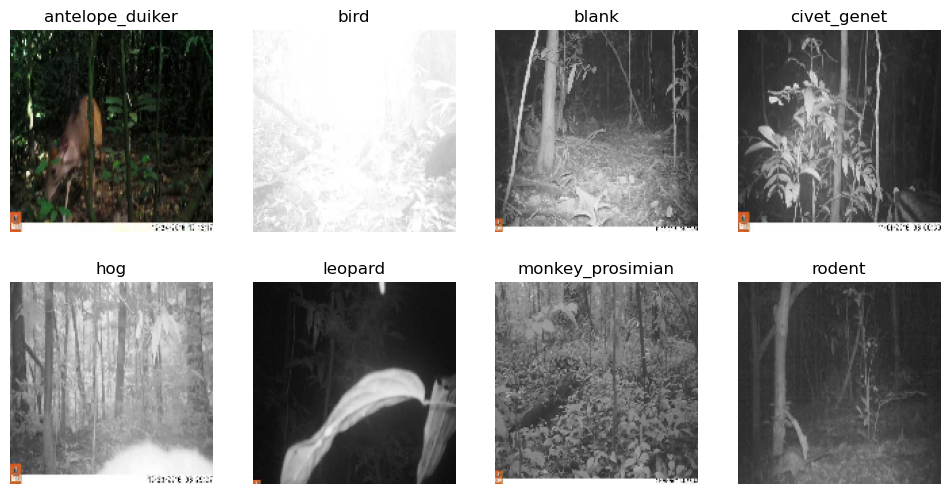

In [9]:
plot_image_samples(train_dir)

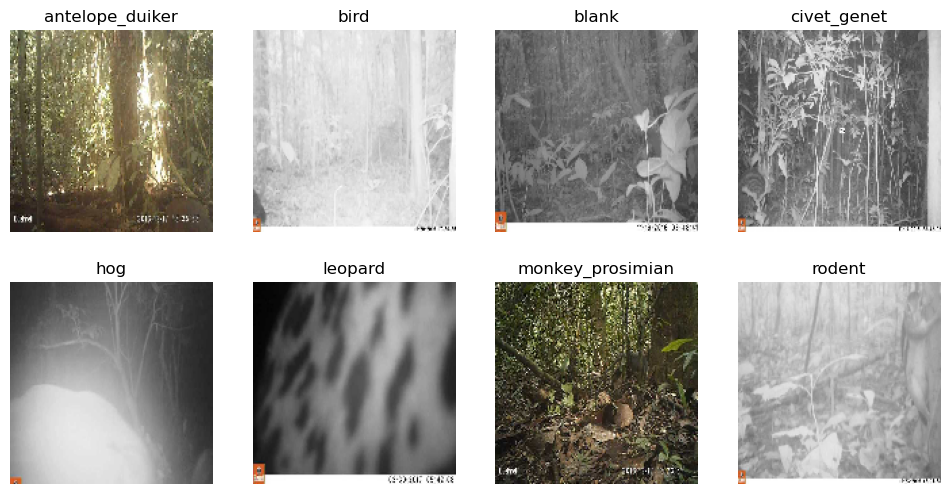

In [10]:
plot_image_samples(train_dir)

The images are captured by automated surveillance systems called **camera traps**, which are triggered by motion or heat. While these systems have the benefit of passively recording the behavior of animal species while limiting human interference in their natural  habitats, the downside is that the captured images are often low resolution and blurry. In addition, it is not immediately clear where an animal may be in the image, as there are various occlusions such as light saturation from nighttime images, trees, bushes, leaves, etc. If the perception task is difficult for humans to perform, it will also be somewhat difficult for a machine learning model to perform.

One additional consequence is that it may not be straightforward to use a pretrained network to boost classification performance. This is because in comparison to this dataset, ImageNet images are clear in quality with minimal occlusions. Thus, it is dubious how well the knowledge from these pretrained networks can be transferred for our task at hand.